<a href="https://colab.research.google.com/github/Umarabdul270/my_poject/blob/master/NomaApp_disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Packages

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# 2. Create Datadrame with images

In [ ]:
data_path = "//content/drive/MyDrive/Data/data"

images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Data Visualization

In [ ]:
data.head()

,image,label
0,//content/drive/MyDrive/Data/data/bean_rust/be...,bean_rust
1,//content/drive/MyDrive/Data/data/bean_rust/be...,bean_rust
2,//content/drive/MyDrive/Data/data/bean_rust/be...,bean_rust
3,//content/drive/MyDrive/Data/data/bean_rust/be...,bean_rust
4,//content/drive/MyDrive/Data/data/bean_rust/be...,bean_rust


In [ ]:
data.shape

(9982, 2)

In [ ]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.81, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (8085, 2)
Validation set shape: (948, 2)
Test set shape: (949, 2)


In [ ]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 8085 validated image filenames belonging to 10 classes.
Found 948 validated image filenames belonging to 10 classes.
Found 949 validated image filenames belonging to 10 classes.


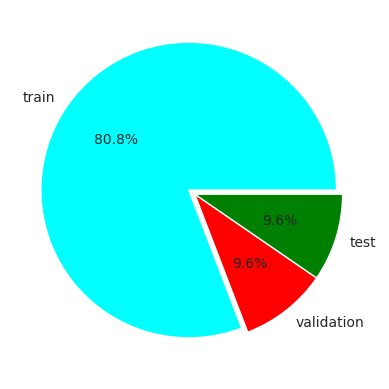

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.show()
plt.savefig('dataset_pie.png')

In [ ]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'Maize_Blight': 0, 'Maize_Common_Rust': 1, 'Maize_Gray_Leaf_Spot': 2, 'Maize_Healthy': 3, 'Rice_Bacterial_leaf_blight': 4, 'Rice_Brown_spot': 5, 'Rice_Leaf_smut': 6, 'bean_angular_leaf_spot': 7, 'bean_healthy': 8, 'bean_rust': 9}
{'Maize_Blight': 0, 'Maize_Common_Rust': 1, 'Maize_Gray_Leaf_Spot': 2, 'Maize_Healthy': 3, 'Rice_Bacterial_leaf_blight': 4, 'Rice_Brown_spot': 5, 'Rice_Leaf_smut': 6, 'bean_angular_leaf_spot': 7, 'bean_healthy': 8, 'bean_rust': 9}
{'Maize_Blight': 0, 'Maize_Common_Rust': 1, 'Maize_Gray_Leaf_Spot': 2, 'Maize_Healthy': 3, 'Rice_Bacterial_leaf_blight': 4, 'Rice_Brown_spot': 5, 'Rice_Leaf_smut': 6, 'bean_angular_leaf_spot': 7, 'bean_healthy': 8, 'bean_rust': 9}


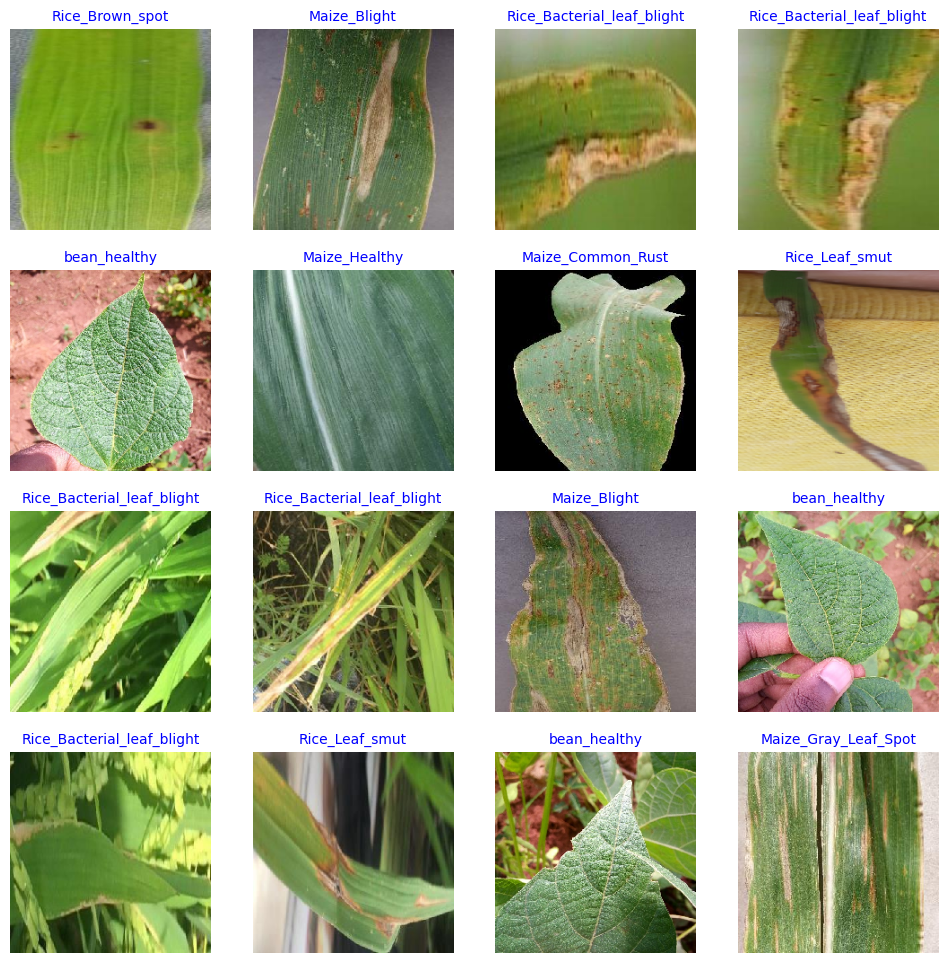

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

# 4. CNN Model

In [ ]:
model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))


model.add(Dense(len(classes), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))



model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 110, 110, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 51, 51, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 430,986 (1.64 MB)

 Trainable params: 430,346 (1.64 MB)

 Non-trainable params: 640 (2.50 KB)

# 5. Callback and Model Compile

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 3164s 12s/step - accuracy: 0.5267 - loss: 1.4869 - val_accuracy: 0.4040 - val_loss: 2.4354
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 54s 213ms/step - accuracy: 0.7378 - loss: 0.7719 - val_accuracy: 0.6540 - val_loss: 1.1141
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.7839 - loss: 0.6490 - val_accuracy: 0.5190 - val_loss: 1.4241
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.8095 - loss: 0.5776 - val_accuracy: 0.6414 - val_loss: 1.0902
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.8348 - loss: 0.4983 - val_accuracy: 0.7046 - val_loss: 0.9237
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 53s 208ms/step - accuracy: 0.8426 - loss: 0.4647 - val_accuracy: 0.4989 - val_loss: 2.4308
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.8530 - loss: 0.4369 - val_accuracy: 0.6414 - val_loss: 1.0526
Epoch 8/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.8720 -

# 6. Accuracy and Loss Curve

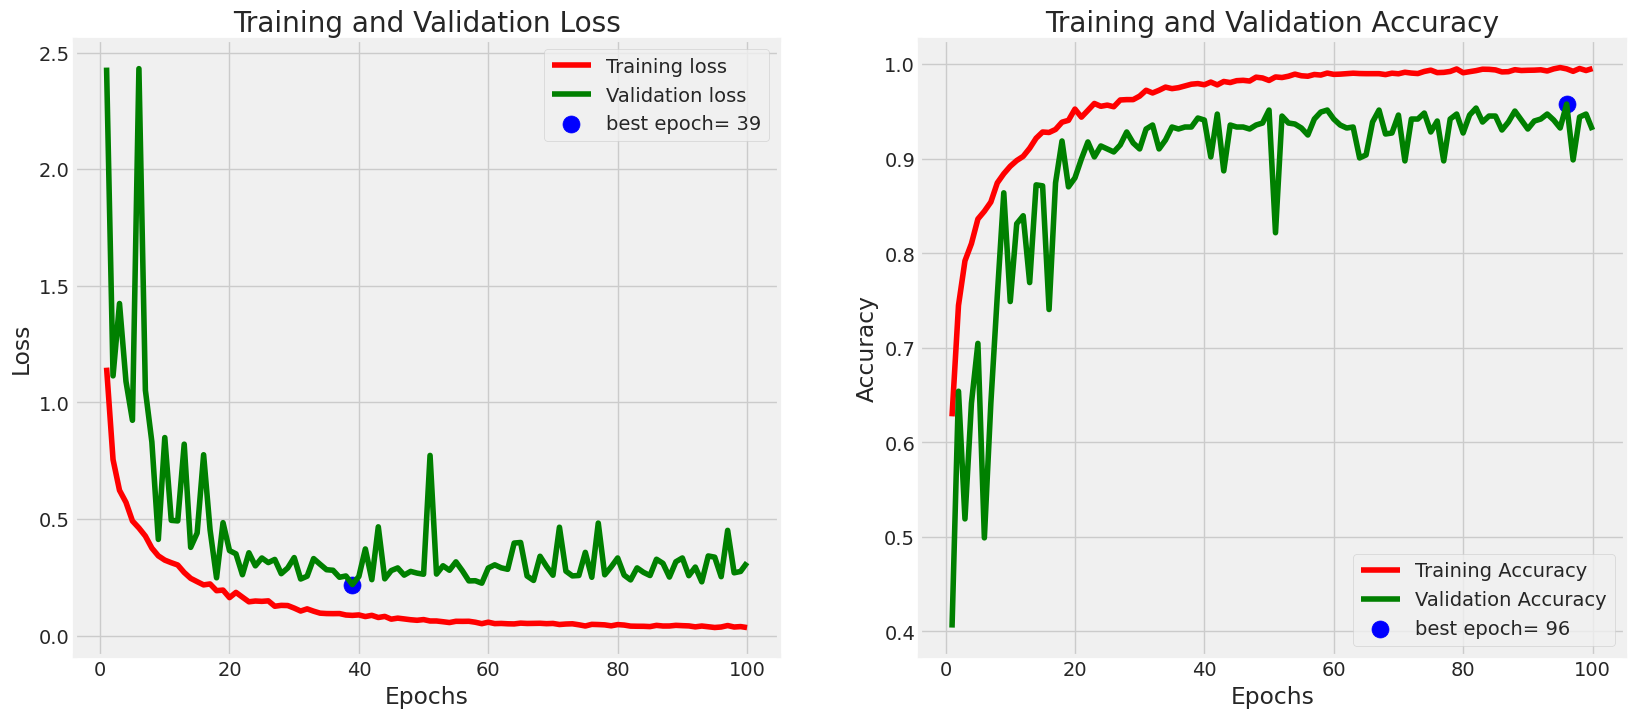

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# 7. Accuracy Score

In [ ]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.9356 - loss: 0.3098
Accuracy score: 0.9303797483444214


In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9844 - loss: 0.0785
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.9457 - loss: 0.2142
13/13 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - accuracy: 0.9367 - loss: 0.2172
Train Loss:  0.0890481099486351
Train Accuracy:  0.9807692170143127
--------------------
Valid Loss:  0.24141015112400055
Valid Accuracy:  0.9447115659713745
--------------------
Test Loss:  0.18812401592731476
Test Accuracy:  0.9495192170143127


# 8. Classification Report

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step


In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                            precision    recall  f1-score   support

              Maize_Blight       0.92      0.83      0.88       109
         Maize_Common_Rust       0.99      0.90      0.95       124
      Maize_Gray_Leaf_Spot       0.71      0.87      0.78        55
             Maize_Healthy       0.96      1.00      0.98       111
Rice_Bacterial_leaf_blight       1.00      0.97      0.99       156
           Rice_Brown_spot       0.97      0.99      0.98       158
            Rice_Leaf_smut       0.97      0.98      0.97       143
    bean_angular_leaf_spot       0.76      0.90      0.82        31
              bean_healthy       0.88      0.97      0.92        31
                 bean_rust       0.91      0.68      0.78        31

                  accuracy                           0.94       949
                 macro avg       0.91      0.91      0.90       949
              weighted avg       0.94      0.94      0.94       949



# 9. Confusion Matrix

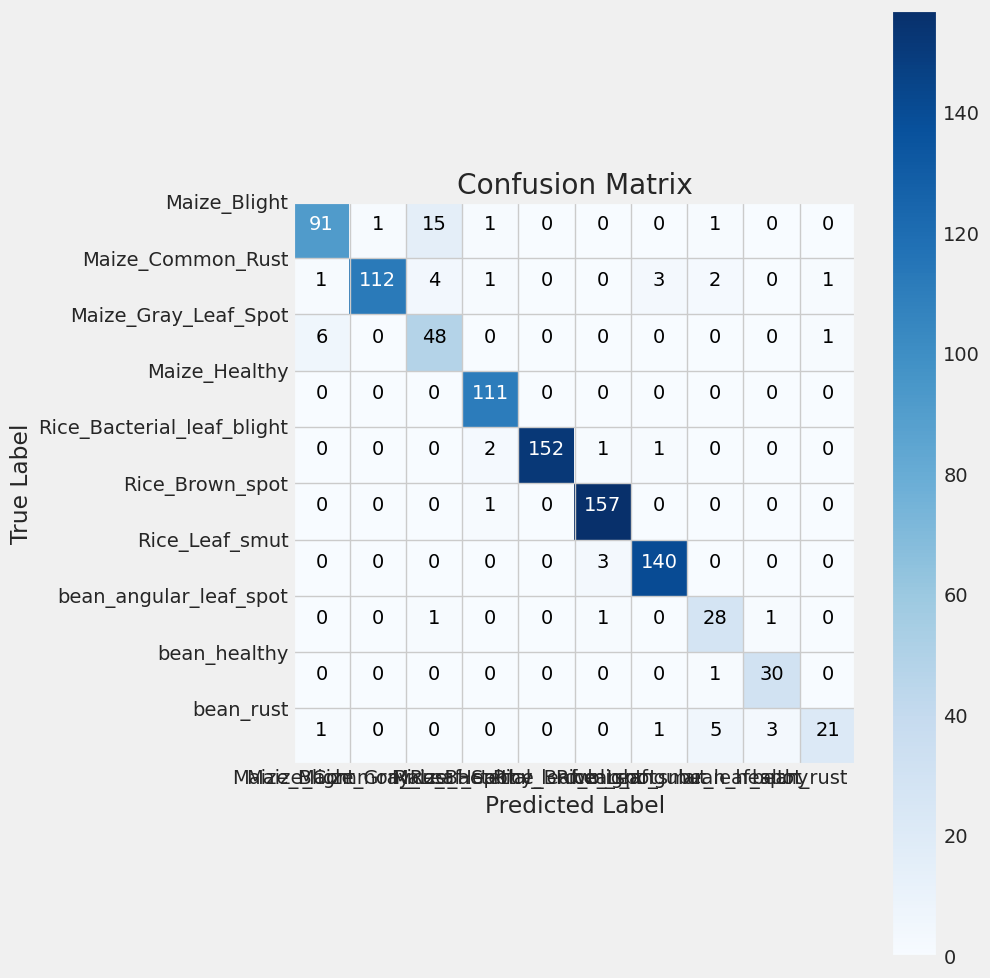

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)
plt.yticks(tick_marks - 0.5, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# 10. Model Save

In [ ]:
model.save('NomaApp_v1.h5')
model.save('NomaApp_v1.keras')

# 11. ROC Curve

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step


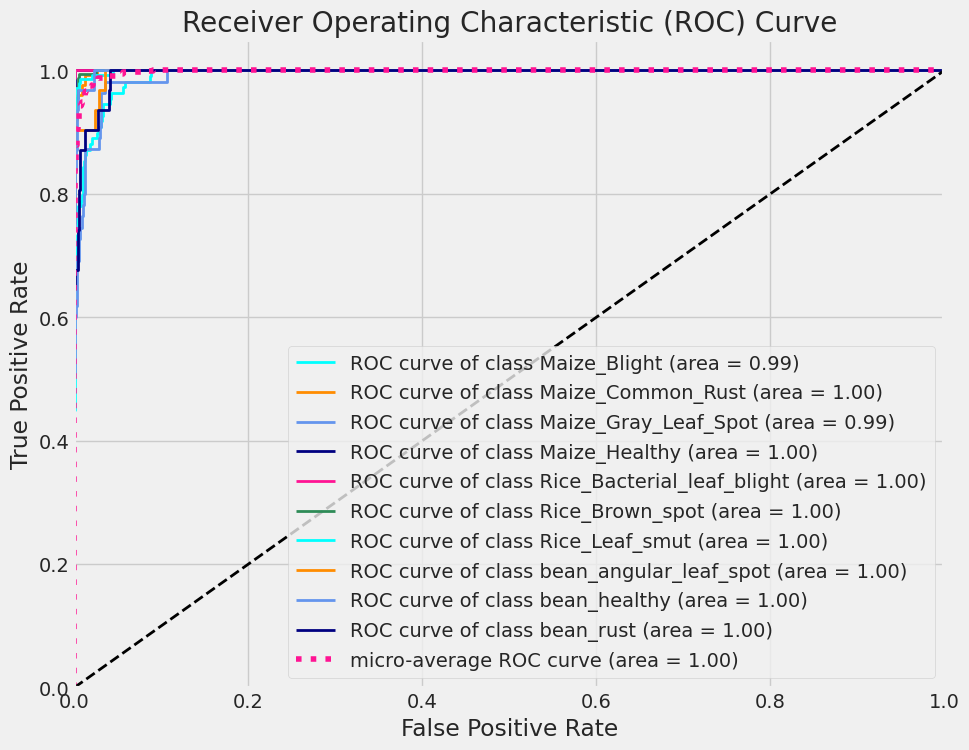

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen)  # Ensure these are the predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 12. AUC Curve

In [ ]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class Maize_Blight: 0.99
AUC for class Maize_Common_Rust: 1.00
AUC for class Maize_Gray_Leaf_Spot: 0.99
AUC for class Maize_Healthy: 1.00
AUC for class Rice_Bacterial_leaf_blight: 1.00
AUC for class Rice_Brown_spot: 1.00
AUC for class Rice_Leaf_smut: 1.00
AUC for class bean_angular_leaf_spot: 1.00
AUC for class bean_healthy: 1.00
AUC for class bean_rust: 1.00
Micro-average AUC: 1.00
Macro-average AUC: 1.00


# 13. ResNet50 Model

In [ ]:
from keras.applications import ResNet50
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = resnet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
resnet_model = Model(inputs, outputs)

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']

)

resnet_model.fit(train_gen, epochs=3, validation_data=valid_gen)

In [ ]:
test_loss, test_acc = resnet_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

test_preds = resnet_model.predict(test_gen)
predicted_labels = np.argmax(test_preds, axis=1)

cm = confusion_matrix(test_gen.classes, predicted_labels)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(test_gen.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Remove the axes
plt.gca().set_axis_off()
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')

plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

true_labels = label_binarize(test_gen.classes, classes=[0, 1, 2, 3])
n_classes = true_labels.shape[1]

predicted_probs = resnet_model.predict(test_gen)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

for i in range(n_classes):
    print(f'AUC for class {i}: {roc_auc[i]:.2f}')
print(f'Micro-averaged AUC: {roc_auc["micro"]:.2f}')


# 14. VGG16 Model

In [ ]:
from keras.applications import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = vgg16_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
vgg16_model = Model(inputs, outputs)

vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg16_model.fit(train_gen, epochs=3, validation_data=valid_gen)

In [ ]:
test_loss, test_acc = vgg16_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)

# 15. MobileNetV2 Model

In [ ]:
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenetv2_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = mobilenetv2_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
mobilenetv2_model = Model(inputs, outputs)

mobilenetv2_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenetv2_model.fit(train_gen, epochs=3, validation_data=valid_gen)

In [ ]:
test_loss, test_acc = mobilenetv2_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)

# 16. DenseNet121 Model

In [ ]:
from keras.applications import DenseNet121
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

densenet121_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet121_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = densenet121_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
densenet121_model = Model(inputs, outputs)

densenet121_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

densenet121_model.fit(train_gen, epochs=3, validation_data=valid_gen)

In [ ]:
test_loss, test_acc = densenet121_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)

# 17. Lime using VGG16 model

In [ ]:
import lime
import lime.lime_image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = VGG16(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img = np.array(Image.open('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (100).JPG').resize((224, 224)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# 18. Lime using ResNet50 Model

In [ ]:
import lime
import lime.lime_image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = ResNet50(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img = np.array(Image.open('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG').resize((224, 224)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')

plt.show()

# 19. Lime using InceptionV3 Model

In [ ]:
import lime
import lime.lime_image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = InceptionV3(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img = np.array(Image.open('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG').resize((299, 299)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()

# 20. Lime using MobileNetV2 Model

In [ ]:
import lime
import lime.lime_image
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = MobileNetV2(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img = np.array(Image.open('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG').resize((224, 224)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()

# 21. Lime using custom CNN model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.models import load_model
import tensorflow as tf

img_path = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG"
img = plt.imread(img_path)

def preprocess_image(image):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image.numpy()

preprocessed_img = preprocess_image(img)

model = load_model('/kaggle/working/model2.h5')

def predict_fn(images):
    processed_images = np.array([preprocess_image(image) for image in images])
    return model.predict(processed_images)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(preprocessed_img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.title('LIME Explanation')
plt.show()

# 22. Shap

In [ ]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data"

image_path = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/model2.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(224,224)", shape=(224, 224, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=5000, outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values_fine)

# END!!! Thanks for Watching